In [1]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
import cv2
import tensorflow.compat.v1 as tf

graph = tf.Graph()
model_fn = 'model/tensorflow_inception_graph.pb'
# https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.GFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [2]:
# 保存图像
def savearray(img_array, img_name):
#     scipy.misc.toimage(img_array).save(img_name)
    cv2.imwrite(img_name,img_array)
    print('img saved:%s'% img_name)

# 将图像放大ratio倍
def resize_ratio(img, ratio):
    min = img.min()
    max = img.max()
    img = (img-min) / (max - min) * 255
#     img = np.float32(scipy.misc.imresize(img, ratio))
    img=cv2.resize(img,(ratio[1],ratio[0]))
    img = img / 255*(max-min) + min
    return img

# 调整图像尺寸
def resize(img, hw):
    min = img.min()
    max = img.max()
    img = (img-min) / (max - min) * 255
#     img = np.float32(scipy.misc.imresize(img, hw))
    img=cv2.resize(img,(hw[1],hw[0]))
    img = img / 255*(max-min) + min
    return img

# 原始图像尺寸可能很大，从而导致内存耗尽问题
# 每次只对tile_size * tile_size大小的图像计算梯度，避免内存问题
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx,1), sy, 0)# 先在行上做整体移动，再在列上做整体移动
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz//2, sz), sz):
        for x in range(0, max(w - sz//2, sz), sz):
            sub = img_shift[y:y+sz, x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)


# 渲染函数,对图像进行拉普拉斯分解
def render_deepdream(t_obj, img0, 
                     iter_n=20, step=1.5, octave_n=4, octave_scale=1.4):
    # t_obj:是layer_output[:,:,:,channel],即卷积层某个通道的值
    # img0:初始图像（噪声图像）
    # iter_n：迭代次数
    # step：用于控制每次迭代步长，可以看作学习率
    # octave_n：金字塔层数
    # octave_scale：层与层之间的倍数
    t_score = tf.reduce_mean(t_obj)
    # t_score是t_obj的平均值
    # 由于我们的目标是调整输入图像使卷积层激活值尽可能大
    # 即最大化t_score
    # 为达到此目标，可使用梯度下降
    # 计算t_score对t_input的梯度
    t_grad = tf.gradients(t_score, t_input)[0]

    img = img0.copy() # 赋值新图像可避免影响原图像的值

    # 将图像进行金字塔分解，从而分为高频、低频部分
    octaves = []
    for i in range(octave_n - 1):
        hw = img.shape[:2]# 图像尺寸
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)

    # 首先生成低频的图像，再依次放大并加上高频
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2]) + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step/np.abs(g).mean()+1e-7)

    img = img.clip(0,255)
    savearray(img, 'mountain_deepdream.jpg')
    im = PIL.Image.open('mountain_deepdream.jpg').show()

img saved:mountain_deepdream.jpg


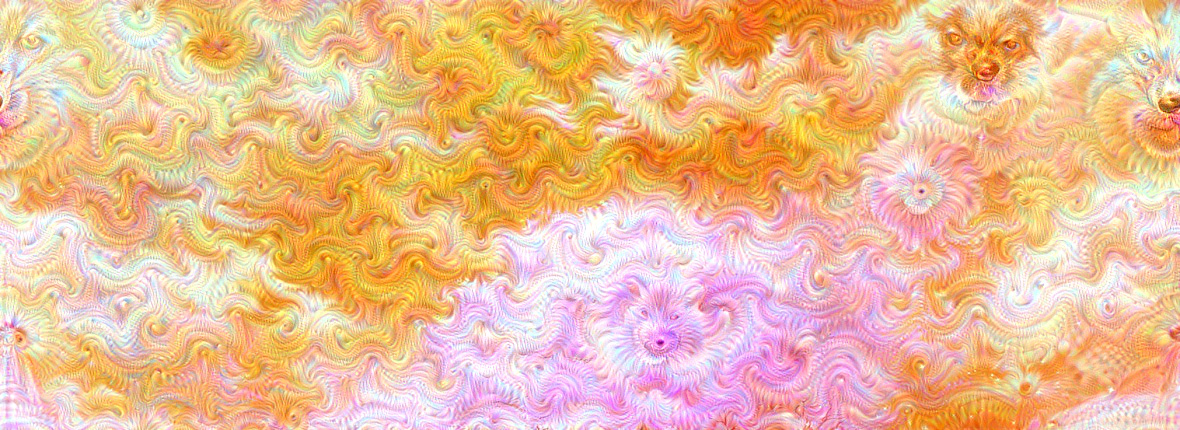

In [3]:
name = 'mixed4c'
layer_output = graph.get_tensor_by_name('import/%s:0' % name)

img0 = PIL.Image.open('image/1.jpg')
img0 = np.float32(img0)
render_deepdream(tf.square(layer_output), img0)
# display(IMG('mountain_deepdream.jpg'))